In [1]:
import cv2

def save_first_last_frame(video_path, output_first='first_frame.jpg', output_last='last_frame.jpg'):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return
    
    # 讀取第一個影格
    ret, first_frame = cap.read()
    if ret:
        cv2.imwrite(output_first, first_frame)
    else:
        print("Error: Cannot read first frame.")
    
    # 移動到最後一個影格
    cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1)
    ret, last_frame = cap.read()
    if ret:
        cv2.imwrite(output_last, last_frame)
    else:
        print("Error: Cannot read last frame.")
    
    cap.release()
    print(f"Frames saved as {output_first} and {output_last}")

# 使用範例
video_file = r'C:\Users\fishd\Desktop\論文\期刊\code\images\new_test1.mp4'  # 請替換為你的影片檔案
save_first_last_frame(video_file)


Frames saved as first_frame.jpg and last_frame.jpg


In [2]:
import cv2
import numpy as np

# 讀取兩張連續影像
img1 = cv2.imread('first_frame.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('last_frame.jpg', cv2.IMREAD_GRAYSCALE)

# 建立 SIFT 特徵點檢測器
sift = cv2.SIFT_create()

# 提取特徵點與描述子
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# 使用 FLANN 進行特徵點匹配
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 進行匹配
matches = flann.knnMatch(des1, des2, k=2)


In [3]:
# 過濾匹配點（Lowe’s Ratio Test）
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# 取得對應的特徵點座標
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 使用 RANSAC 計算 Homography 矩陣
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

# 找出 RANSAC 判定的 inliers（內點）與 outliers（離群點）
inliers = pts1[mask.ravel() == 1]  # 內點
outliers = pts1[mask.ravel() == 0]  # 離群點

print(f"內點數量: {len(inliers)}, 離群點數量: {len(outliers)}")


內點數量: 9169, 離群點數量: 149


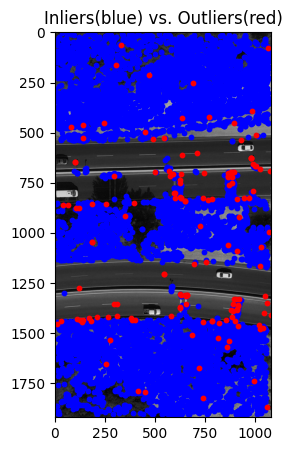

In [4]:
import matplotlib.pyplot as plt

# 繪製原始影像
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB))

# 繪製內點（藍色）
for p in inliers:
    plt.scatter(p[0][0], p[0][1], color='blue', s=10)

# 繪製離群點（紅色）
for p in outliers:
    plt.scatter(p[0][0], p[0][1], color='red', s=10)

plt.title("Inliers(blue) vs. Outliers(red)")
plt.show()


In [1]:
import cv2
import numpy as np

# 讀取兩張影像

img1 = cv2.imread('first_frame.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('last_frame.jpg', cv2.IMREAD_GRAYSCALE)
# 計算 Farneback 光流
flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# 根據光流變換來對齊影像
h, w = flow.shape[:2]
flow_map = np.column_stack((np.repeat(np.arange(h), w), np.tile(np.arange(w), h))) + flow.reshape(-1, 2)

# 生成變形後的影像
aligned_frame2 = cv2.remap(img2, flow_map[:, 1].reshape(h, w).astype(np.float32),
                           flow_map[:, 0].reshape(h, w).astype(np.float32), cv2.INTER_LINEAR)

cv2.imshow("Aligned Frame", aligned_frame2)
cv2.waitKey(0)


-1